## LSTM 时间序列预测+股票预测案例(Pytorch版)
## https://blog.csdn.net/qq_44824148/article/details/126222872

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

filepath = './stock_data.csv'
data = pd.read_csv(filepath)
# 将数据按照日期进行排序，确保时间序列递增
data = data.sort_values('Date')
# 打印前几条数据
print(data.head())
# 打印维度
print(data.shape)


         Date        Open        High         Low       Close   Adj Close  \
0  2018-05-23  182.500000  186.910004  182.179993  186.899994  186.899994   
1  2018-05-24  185.880005  186.800003  185.029999  185.929993  185.929993   
2  2018-05-25  186.020004  186.330002  184.449997  184.919998  184.919998   
3  2018-05-29  184.339996  186.809998  183.710007  185.740005  185.740005   
4  2018-05-30  186.539993  188.000000  185.250000  187.669998  187.669998   

     Volume  
0  16628100  
1  12354700  
2  10965100  
3  16398900  
4  13736900  
(252, 7)


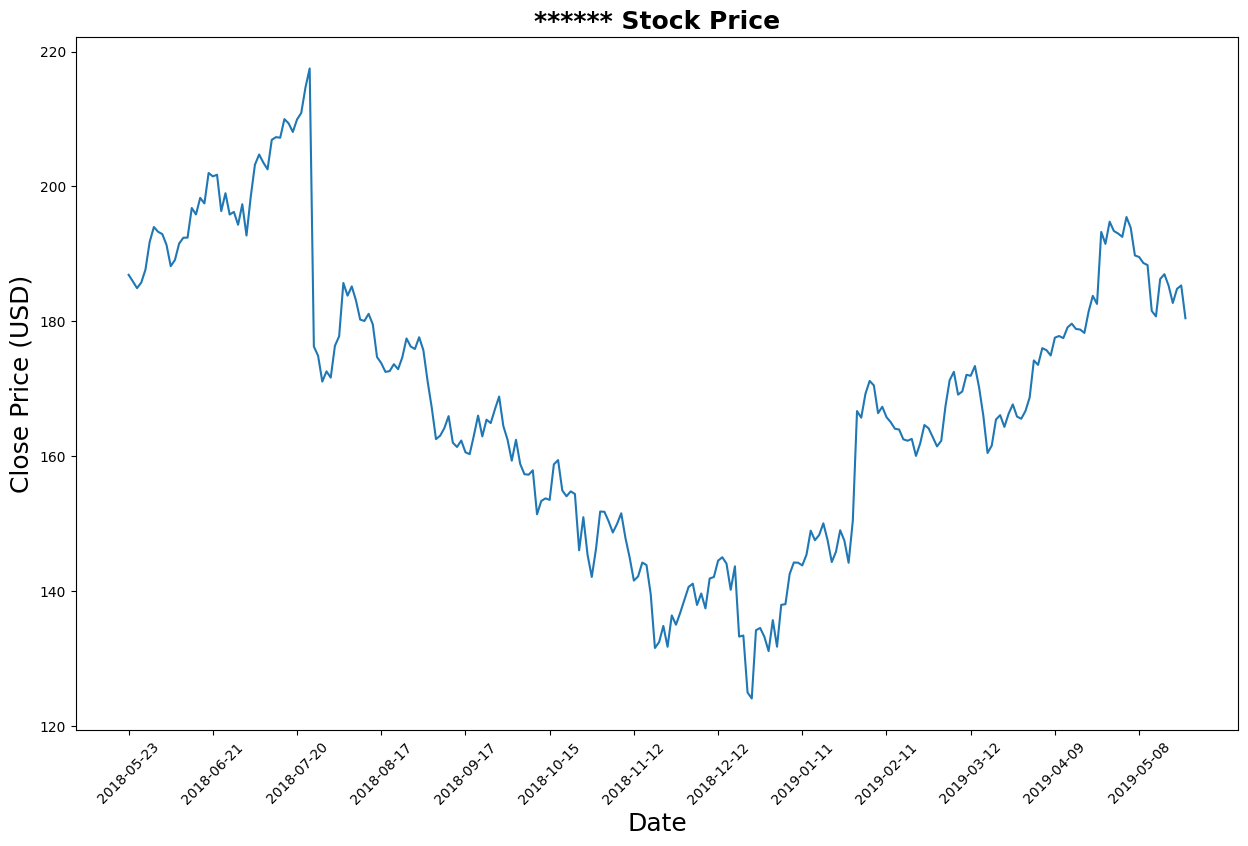

In [2]:
# 设置画布大小
plt.figure(figsize=(15, 9))
plt.plot(data[['Close']])
plt.xticks(range(0, data.shape[0], 20), data['Date'].loc[::20], rotation=45)
plt.title("****** Stock Price", fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price (USD)', fontsize=18)
plt.savefig('StockPrice.jpg')
plt.show()


In [3]:
# 选取Close作为特征
price = data[['Close']]
# 打印相关信息
print(price.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   252 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB
None


In [4]:
# 进行不同的数据缩放，将数据缩放到-1和1之间，归一化操作
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1, 1))
print(price['Close'].shape)


(252,)


/tmp/ipykernel_828912/1079393986.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1, 1))


In [5]:
price.iloc[:22]

,Close
0,0.345034
1,0.324272
2,0.302654
3,0.320206
4,0.361515
5,0.449486
6,0.496790
7,0.481592
8,0.474315
9,0.440068


In [6]:
# 今天的收盘价预测明天的收盘价
# lookback表示观察的跨度
def split_data(stock, lookback):
	# 将stock转化为ndarray类型
    data_raw = stock.to_numpy()
    data = []

    # you can free play（seq_length）
    # 将data按lookback分组，data为长度为lookback的list
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])
	
    data = np.array(data);
    print(type(data))  # (232, 20, 1)
    # 按照8:2进行训练集、测试集划分
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]

    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1, :]

    return [x_train, y_train, x_test, y_test]

lookback = 20
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)


<class 'numpy.ndarray'>
x_train.shape =  (186, 19, 1)
y_train.shape =  (186, 1)
x_test.shape =  (46, 19, 1)
y_test.shape =  (46, 1)


In [7]:
x_train[:2]

array([[[0.34503413],
        [0.32427212],
        [0.30265408],
        [0.3202056 ],
        [0.36151538],
        [0.44948629],
        [0.4967895 ],
        [0.48159246],
        [0.47431512],
        [0.44006842],
        [0.37243137],
        [0.39212343],
        [0.44434918],
        [0.46275673],
        [0.46297099],
        [0.55714894],
        [0.53660117],
        [0.5892551 ],
        [0.57170388]],

       [[0.32427212],
        [0.30265408],
        [0.3202056 ],
        [0.36151538],
        [0.44948629],
        [0.4967895 ],
        [0.48159246],
        [0.47431512],
        [0.44006842],
        [0.37243137],
        [0.39212343],
        [0.44434918],
        [0.46275673],
        [0.46297099],
        [0.55714894],
        [0.53660117],
        [0.5892551 ],
        [0.57170388],
        [0.66823631]]])

In [8]:
y_train[:3]

array([[0.66823631],
       [0.65753425],
       [0.66267135]])

### LSTM model doesn't need to know sequence length

In [9]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
# 真实的数据
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

# 输入的维度为1，只有Close收盘价
input_dim = 1
# 隐藏层特征的维度
hidden_dim = 32
# 循环的layers
num_layers = 2
# 预测后一天的收盘价
output_dim = 1
num_epochs = 100


class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        print(f"x.size(0): {x.size(0)}")
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        print(f"out shape: {out.shape}")
        out = self.fc(out[:, -1, :])   ### here out was batch X sequence X output_dim ( only keep the last one)
        return out



model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


In [10]:
x_train.size()

torch.Size([186, 19, 1])

In [11]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time() - start_time
print("Training time: {}".format(training_time))

predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
print(predict)  # 预测值
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))
print(original)  # 真实值


x.size(0): 186
out shape: torch.Size([186, 19, 32])
Epoch  0 MSE:  0.20582625269889832
x.size(0): 186
out shape: torch.Size([186, 19, 32])
Epoch  1 MSE:  0.18956544995307922
x.size(0): 186
out shape: torch.Size([186, 19, 32])
Epoch  2 MSE:  0.1673581302165985
x.size(0): 186
out shape: torch.Size([186, 19, 32])
Epoch  3 MSE:  0.13451075553894043
x.size(0): 186
out shape: torch.Size([186, 19, 32])
Epoch  4 MSE:  0.07607712596654892
x.size(0): 186
out shape: torch.Size([186, 19, 32])
Epoch  5 MSE:  0.04078732430934906
x.size(0): 186
out shape: torch.Size([186, 19, 32])
Epoch  6 MSE:  0.13292831182479858
x.size(0): 186
out shape: torch.Size([186, 19, 32])
Epoch  7 MSE:  0.039532434195280075
x.size(0): 186
out shape: torch.Size([186, 19, 32])
Epoch  8 MSE:  0.03696126118302345
x.size(0): 186
out shape: torch.Size([186, 19, 32])
Epoch  9 MSE:  0.0520244725048542
x.size(0): 186
out shape: torch.Size([186, 19, 32])
Epoch  10 MSE:  0.0615985170006752
x.size(0): 186
out shape: torch.Size([186, 1

RangeIndex(start=0, stop=186, step=1)
aaaa
0      196.836273
1      200.531372
2      200.561050
3      200.353745
4      195.577423
          ...    
181    170.698730
182    171.478973
183    172.748657
184    170.083755
185    165.614212
Name: 0, Length: 186, dtype: float32


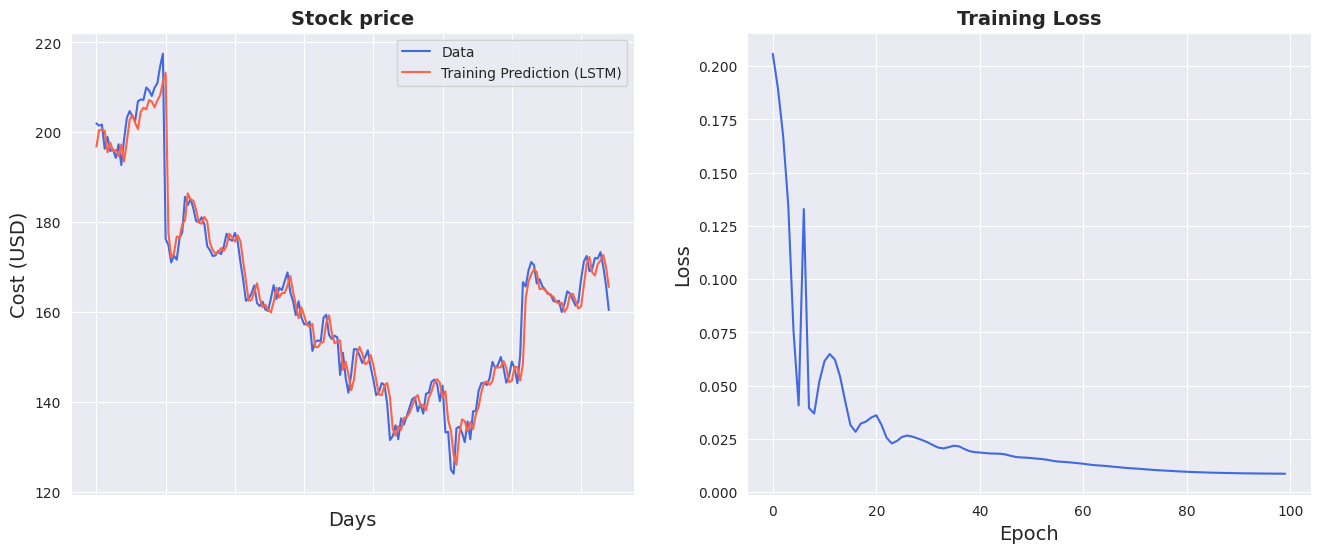

In [12]:
import seaborn as sns
sns.set_style("darkgrid")

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
print(predict.index)
print("aaaa")
print(predict[0])


ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)
plt.show()


In [13]:
type(y_train_pred)

torch.Tensor

In [14]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()


x.size(0): 46
out shape: torch.Size([46, 19, 32])
Train Score: 4.36 RMSE
Test Score: 2.95 RMSE
